# Notebook 1: RL 기초 - MDP와 가치 함수

## 🎯 학습 목표
- 강화학습의 핵심 개념 이해
- MDP (Markov Decision Process) 구조 파악
- 가치 함수와 Bellman 방정식 학습
- GridWorld에서 정책 평가와 가치 반복 구현

## 1. 강화학습이란?

강화학습(Reinforcement Learning)은 **에이전트(Agent)**가 **환경(Environment)**과 상호작용하며 **보상(Reward)**을 최대화하는 **행동(Action)**을 학습하는 방법입니다.

### 핵심 구성 요소
- **Agent**: 학습하고 결정을 내리는 주체
- **Environment**: 에이전트가 상호작용하는 세계
- **State (s)**: 현재 상황을 나타내는 정보
- **Action (a)**: 에이전트가 취할 수 있는 행동
- **Reward (r)**: 행동의 결과로 받는 즉각적 보상
- **Policy (π)**: 상태에서 행동을 선택하는 전략
- **Value (V)**: 장기적 기대 보상

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Optional
from dataclasses import dataclass
from enum import Enum
import random

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("RL 기초 학습 환경 준비 완료!")

RL 기초 학습 환경 준비 완료!


## 2. Markov Decision Process (MDP)

MDP는 강화학습 문제를 수학적으로 정의하는 프레임워크입니다.

### MDP 구성 요소
- **S**: 상태 공간 (State space)
- **A**: 행동 공간 (Action space)  
- **P(s'|s,a)**: 상태 전이 확률 (Transition probability)
- **R(s,a,s')**: 보상 함수 (Reward function)
- **γ**: 할인 인자 (Discount factor) ∈ [0,1]

### Markov 속성
미래는 현재 상태에만 의존하고, 과거 이력과는 무관합니다:
$$P(s_{t+1}|s_t, a_t, s_{t-1}, a_{t-1}, ...) = P(s_{t+1}|s_t, a_t)$$

MDP 생성: 5x5 그리드
시작: (0,0), 목표: (4,4), 함정: (2,2)


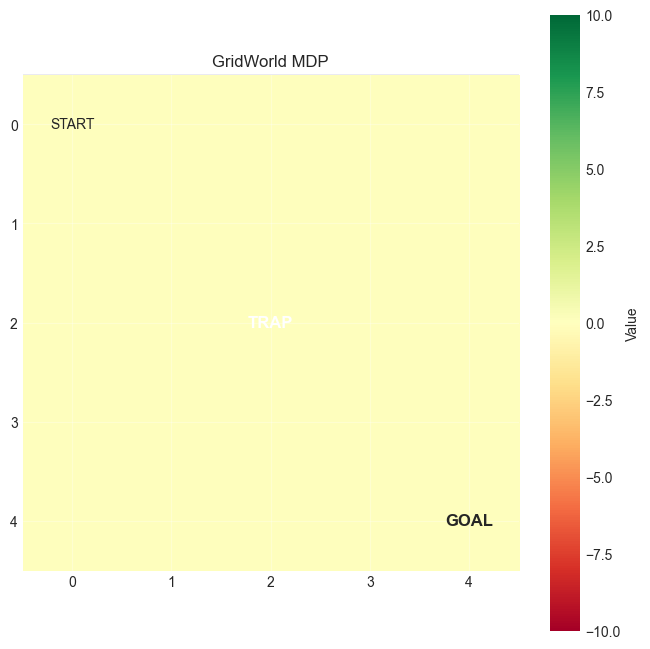

In [4]:
class Action(Enum):
    """가능한 행동들"""
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    
    @classmethod
    def all(cls):
        return list(cls)

@dataclass
class State:
    """상태를 나타내는 클래스"""
    x: int
    y: int
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

class GridWorldMDP:
    """간단한 GridWorld MDP 환경"""
    
    def __init__(self, width: int = 5, height: int = 5):
        self.width = width
        self.height = height
        self.states = [State(x, y) for x in range(width) for y in range(height)]
        self.actions = Action.all()
        
        # 특수 상태 정의
        self.goal_state = State(width-1, height-1)  # 우하단 목표
        self.trap_state = State(2, 2)  # 중앙 함정
        self.start_state = State(0, 0)  # 좌상단 시작
        
        # 할인 인자
        self.gamma = 0.9
    
    def is_terminal(self, state: State) -> bool:
        """종료 상태 확인"""
        return state == self.goal_state or state == self.trap_state
    
    def get_next_state(self, state: State, action: Action) -> State:
        """결정적 상태 전이 (deterministic transition)"""
        if self.is_terminal(state):
            return state
        
        x, y = state.x, state.y
        
        if action == Action.UP:
            y = max(0, y - 1)
        elif action == Action.DOWN:
            y = min(self.height - 1, y + 1)
        elif action == Action.LEFT:
            x = max(0, x - 1)
        elif action == Action.RIGHT:
            x = min(self.width - 1, x + 1)
            
        return State(x, y)
    
    def get_reward(self, state: State, action: Action, next_state: State) -> float:
        """보상 함수"""
        if next_state == self.goal_state:
            return 10.0  # 목표 도달
        elif next_state == self.trap_state:
            return -10.0  # 함정에 빠짐
        else:
            return -0.1  # 각 스텝마다 작은 패널티
    
    def visualize(self, values: Optional[Dict[State, float]] = None, 
                  policy: Optional[Dict[State, Action]] = None):
        """환경 시각화"""
        grid = np.zeros((self.height, self.width))
        
        if values:
            for state, value in values.items():
                grid[state.y, state.x] = value
        
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # 가치 함수 히트맵
        im = ax.imshow(grid, cmap='RdYlGn', vmin=-10, vmax=10)
        
        # 정책 화살표
        if policy:
            for state, action in policy.items():
                if not self.is_terminal(state):
                    dx, dy = 0, 0
                    if action == Action.UP: dy = -0.3
                    elif action == Action.DOWN: dy = 0.3
                    elif action == Action.LEFT: dx = -0.3
                    elif action == Action.RIGHT: dx = 0.3
                    
                    ax.arrow(state.x, state.y, dx, dy, 
                            head_width=0.1, head_length=0.1, 
                            fc='black', ec='black')
        
        # 특수 상태 표시
        ax.text(self.goal_state.x, self.goal_state.y, 'GOAL', 
               ha='center', va='center', fontsize=12, fontweight='bold')
        ax.text(self.trap_state.x, self.trap_state.y, 'TRAP', 
               ha='center', va='center', fontsize=12, fontweight='bold', color='white')
        ax.text(self.start_state.x, self.start_state.y, 'START', 
               ha='center', va='center', fontsize=10)
        
        # 격자 표시
        ax.set_xticks(np.arange(self.width))
        ax.set_yticks(np.arange(self.height))
        ax.grid(True, alpha=0.3)
        
        plt.colorbar(im, ax=ax, label='Value')
        plt.title('GridWorld MDP')
        plt.show()

# MDP 환경 생성 및 시각화
mdp = GridWorldMDP()
print(f"MDP 생성: {mdp.width}x{mdp.height} 그리드")
print(f"시작: (0,0), 목표: ({mdp.width-1},{mdp.height-1}), 함정: (2,2)")
mdp.visualize()

## 3. 가치 함수 (Value Functions)

### 상태 가치 함수 V(s)
상태 s에서 시작하여 정책 π를 따를 때의 기대 누적 보상:
$$V^\pi(s) = E_\pi[\sum_{t=0}^\infty \gamma^t r_{t+1} | s_0 = s]$$

### 행동 가치 함수 Q(s,a)
상태 s에서 행동 a를 취한 후 정책 π를 따를 때의 기대 누적 보상:
$$Q^\pi(s,a) = E_\pi[\sum_{t=0}^\infty \gamma^t r_{t+1} | s_0 = s, a_0 = a]$$

### Bellman 방정식
가치 함수는 재귀적 관계를 만족합니다:
$$V^\pi(s) = \sum_a \pi(a|s) \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^\pi(s')]$$

정책 평가 수렴 (반복: 20)

랜덤 정책의 가치 함수:
시작 상태 V(0,0) = -2.30
목표 근처 V(3,3) = -0.43
함정 근처 V(2,1) = -4.62


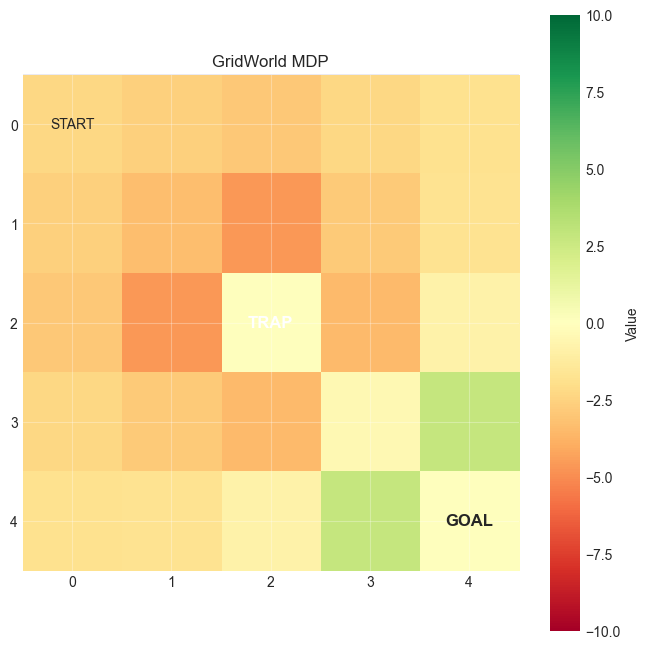

In [5]:
class Policy:
    """정책 클래스"""
    
    def __init__(self, mdp: GridWorldMDP):
        self.mdp = mdp
        self.policy_dict = {}
    
    def get_action(self, state: State) -> Action:
        """상태에 대한 행동 반환"""
        return self.policy_dict.get(state, random.choice(self.mdp.actions))
    
    def get_action_prob(self, state: State, action: Action) -> float:
        """π(a|s) - 결정적 정책"""
        return 1.0 if self.get_action(state) == action else 0.0

class RandomPolicy(Policy):
    """랜덤 정책"""
    
    def get_action_prob(self, state: State, action: Action) -> float:
        """모든 행동에 동일한 확률"""
        return 1.0 / len(self.mdp.actions)

def policy_evaluation(mdp: GridWorldMDP, policy: Policy, 
                     theta: float = 0.01, max_iters: int = 1000) -> Dict[State, float]:
    """
    정책 평가: 주어진 정책의 가치 함수 계산
    Iterative Policy Evaluation 알고리즘 사용
    """
    # 가치 함수 초기화
    V = {state: 0.0 for state in mdp.states}
    
    for iteration in range(max_iters):
        delta = 0
        
        # 모든 상태에 대해 업데이트
        for state in mdp.states:
            if mdp.is_terminal(state):
                continue
                
            v = V[state]
            new_v = 0
            
            # Bellman Expectation Equation
            for action in mdp.actions:
                next_state = mdp.get_next_state(state, action)
                reward = mdp.get_reward(state, action, next_state)
                
                # π(a|s) * [R + γV(s')]
                new_v += policy.get_action_prob(state, action) * \
                        (reward + mdp.gamma * V[next_state])
            
            V[state] = new_v
            delta = max(delta, abs(v - new_v))
        
        if delta < theta:
            print(f"정책 평가 수렴 (반복: {iteration})")
            break
    
    return V

# 랜덤 정책 평가
random_policy = RandomPolicy(mdp)
V_random = policy_evaluation(mdp, random_policy)

print("\n랜덤 정책의 가치 함수:")
print(f"시작 상태 V(0,0) = {V_random[State(0,0)]:.2f}")
print(f"목표 근처 V(3,3) = {V_random[State(3,3)]:.2f}")
print(f"함정 근처 V(2,1) = {V_random[State(2,1)]:.2f}")

mdp.visualize(values=V_random)

## 4. 가치 반복 (Value Iteration)

가치 반복은 **최적 가치 함수** $V^*$를 직접 계산하는 동적 프로그래밍 방법입니다.

### Bellman Optimality Equation
$$V^*(s) = \max_a \sum_{s'} P(s'|s,a)[R(s,a,s') + \gamma V^*(s')]$$

### 알고리즘
1. 모든 상태의 가치를 0으로 초기화
2. 수렴할 때까지 반복:
   - 각 상태에 대해 모든 행동의 가치를 계산
   - 최대 가치를 선택하여 업데이트
3. 최적 정책 추출

가치 반복 수렴 (반복: 8)

최적 가치 함수:
시작 상태 V*(0,0) = 4.26
목표 근처 V*(3,3) = 8.90
함정 근처 V*(2,1) = 6.22

최적 정책 (화살표로 표시):


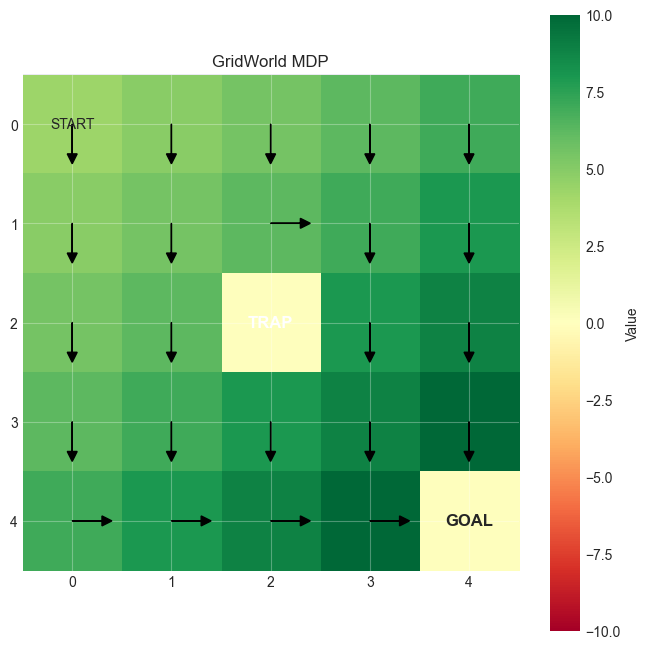

In [8]:
def value_iteration(mdp: GridWorldMDP, theta: float = 0.01, 
                   max_iters: int = 1000) -> Tuple[Dict[State, float], Dict[State, Action]]:
    """
    가치 반복: 최적 가치 함수와 최적 정책 계산
    """
    # 가치 함수 초기화
    V = {state: 0.0 for state in mdp.states}
    
    # 가치 반복
    for iteration in range(max_iters):
        delta = 0
        
        for state in mdp.states:
            if mdp.is_terminal(state):
                continue
            
            v = V[state]
            
            # Bellman Optimality Equation
            action_values = []
            for action in mdp.actions:
                next_state = mdp.get_next_state(state, action)
                reward = mdp.get_reward(state, action, next_state)
                action_value = reward + mdp.gamma * V[next_state]
                action_values.append(action_value)
            
            V[state] = max(action_values)
            delta = max(delta, abs(v - V[state]))
        
        if delta < theta:
            print(f"가치 반복 수렴 (반복: {iteration})")
            break
    
    # 최적 정책 추출
    policy = {}
    for state in mdp.states:
        if mdp.is_terminal(state):
            continue
        
        action_values = []
        for action in mdp.actions:
            next_state = mdp.get_next_state(state, action)
            reward = mdp.get_reward(state, action, next_state)
            action_value = reward + mdp.gamma * V[next_state]
            action_values.append((action_value, action))
        
        policy[state] = max(action_values, key=lambda x: x[0])[1]
    
    return V, policy

# 가치 반복 실행
V_optimal, policy_optimal = value_iteration(mdp)

print("\n최적 가치 함수:")
print(f"시작 상태 V*(0,0) = {V_optimal[State(0,0)]:.2f}")
print(f"목표 근처 V*(3,3) = {V_optimal[State(3,3)]:.2f}")
print(f"함정 근처 V*(2,1) = {V_optimal[State(2,1)]:.2f}")

print("\n최적 정책 (화살표로 표시):")
mdp.visualize(values=V_optimal, policy=policy_optimal)

## 5. 정책 반복 (Policy Iteration)

정책 반복은 정책 평가와 정책 개선을 번갈아가며 수행합니다.

### 알고리즘
1. 임의의 정책으로 시작
2. 수렴할 때까지 반복:
   - **정책 평가**: 현재 정책의 가치 함수 계산
   - **정책 개선**: 가치 함수를 기반으로 더 나은 정책 선택

In [9]:
def policy_iteration(mdp: GridWorldMDP, max_iters: int = 100) -> Tuple[Dict[State, float], Dict[State, Action]]:
    """
    정책 반복: 정책 평가와 개선을 반복하여 최적 정책 찾기
    """
    # 임의의 정책으로 초기화 (모두 위로 가기)
    policy = Policy(mdp)
    for state in mdp.states:
        policy.policy_dict[state] = Action.UP
    
    for iteration in range(max_iters):
        # 1. 정책 평가
        V = policy_evaluation(mdp, policy, theta=0.01)
        
        # 2. 정책 개선
        policy_stable = True
        
        for state in mdp.states:
            if mdp.is_terminal(state):
                continue
            
            old_action = policy.get_action(state)
            
            # 각 행동의 가치 계산
            action_values = []
            for action in mdp.actions:
                next_state = mdp.get_next_state(state, action)
                reward = mdp.get_reward(state, action, next_state)
                action_value = reward + mdp.gamma * V[next_state]
                action_values.append((action_value, action))
            
            # 최선의 행동 선택 (greedy)
            best_action = max(action_values, key=lambda x: x[0])[1]
            policy.policy_dict[state] = best_action
            
            if old_action != best_action:
                policy_stable = False
        
        if policy_stable:
            print(f"정책 반복 수렴 (반복: {iteration})")
            break
    
    return V, policy.policy_dict

# 정책 반복 실행
V_pi, policy_pi = policy_iteration(mdp)

print("\n정책 반복 결과:")
print(f"시작 상태 V(0,0) = {V_pi[State(0,0)]:.2f}")

# 가치 반복과 정책 반복 결과 비교
print("\n=== 가치 반복 vs 정책 반복 비교 ===")
print(f"가치 함수 차이: {sum(abs(V_optimal[s] - V_pi[s]) for s in mdp.states):.6f}")
print("동일한 최적 정책 도출:", policy_optimal == policy_pi)

정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 22)
정책 평가 수렴 (반복: 8)
정책 반복 수렴 (반복: 8)

정책 반복 결과:
시작 상태 V(0,0) = 4.26

=== 가치 반복 vs 정책 반복 비교 ===
가치 함수 차이: 0.000000
동일한 최적 정책 도출: False


## 6. 탐색 vs 활용 (Exploration vs Exploitation)

강화학습의 핵심 딜레마: 알려진 좋은 행동을 계속할 것인가(활용), 더 나은 행동을 찾을 것인가(탐색)?

### ε-greedy 정책
- 확률 ε로 랜덤 행동 (탐색)
- 확률 1-ε로 최선의 행동 (활용)

ε=0.0: 평균 보상 = 4.26
ε=0.1: 평균 보상 = 3.73
ε=0.3: 평균 보상 = 2.40
ε=0.5: 평균 보상 = 1.10
ε=1.0: 평균 보상 = -2.59


/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45572 (\N{HANGUL SYLLABLE NU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:17

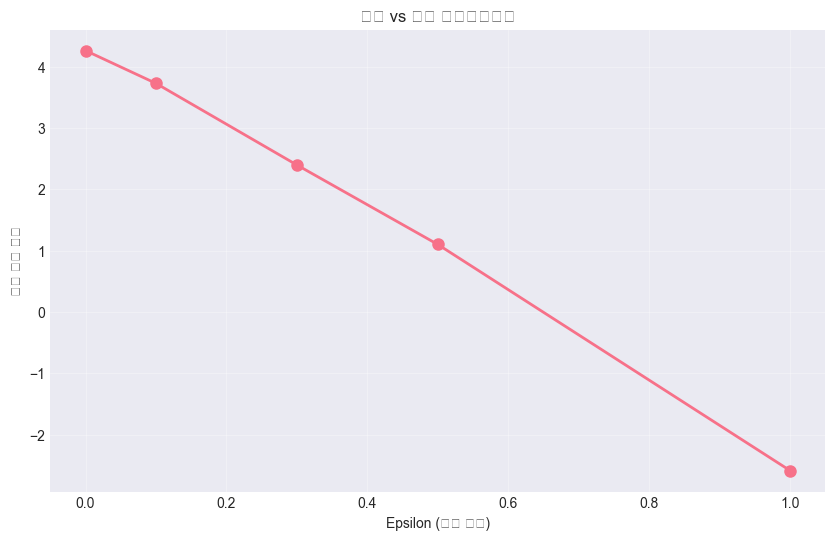

In [10]:
class EpsilonGreedyPolicy(Policy):
    """ε-greedy 정책"""
    
    def __init__(self, mdp: GridWorldMDP, Q: Dict[Tuple[State, Action], float], 
                 epsilon: float = 0.1):
        super().__init__(mdp)
        self.Q = Q
        self.epsilon = epsilon
    
    def get_action(self, state: State) -> Action:
        """ε-greedy 행동 선택"""
        if random.random() < self.epsilon:
            # 탐색: 랜덤 행동
            return random.choice(self.mdp.actions)
        else:
            # 활용: 최선의 행동
            q_values = [(self.Q.get((state, a), 0), a) for a in self.mdp.actions]
            return max(q_values, key=lambda x: x[0])[1]

def simulate_episode(mdp: GridWorldMDP, policy: Policy, max_steps: int = 100) -> float:
    """에피소드 시뮬레이션"""
    state = mdp.start_state
    total_reward = 0
    discount = 1.0
    
    for step in range(max_steps):
        if mdp.is_terminal(state):
            break
        
        action = policy.get_action(state)
        next_state = mdp.get_next_state(state, action)
        reward = mdp.get_reward(state, action, next_state)
        
        total_reward += discount * reward
        discount *= mdp.gamma
        state = next_state
    
    return total_reward

# 다양한 epsilon 값으로 성능 비교
epsilons = [0.0, 0.1, 0.3, 0.5, 1.0]
results = []

# 간단한 Q 테이블 (최적 정책 기반)
Q_table = {}
for state in mdp.states:
    for action in mdp.actions:
        next_state = mdp.get_next_state(state, action)
        reward = mdp.get_reward(state, action, next_state)
        Q_table[(state, action)] = reward + mdp.gamma * V_optimal.get(next_state, 0)

for epsilon in epsilons:
    policy = EpsilonGreedyPolicy(mdp, Q_table, epsilon)
    rewards = [simulate_episode(mdp, policy) for _ in range(100)]
    avg_reward = np.mean(rewards)
    results.append(avg_reward)
    print(f"ε={epsilon:.1f}: 평균 보상 = {avg_reward:.2f}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(epsilons, results, 'o-', linewidth=2, markersize=8)
plt.xlabel('Epsilon (탐색 확률)')
plt.ylabel('평균 누적 보상')
plt.title('탐색 vs 활용 트레이드오프')
plt.grid(True, alpha=0.3)
plt.show()

## 7. 실습: 복잡한 GridWorld

이제 벽과 여러 함정이 있는 더 복잡한 환경에서 학습해봅시다.

복잡한 GridWorld 생성 완료
벽: 8개, 함정: 3개

가치 반복 실행 중...
가치 반복 수렴 (반복: 42)

학습된 최적 정책:


/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9760 (\N{SKULL AND CROSSBONES}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9670 (\N{BLACK DIAMOND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/gd452/Development/my-llm-lab/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


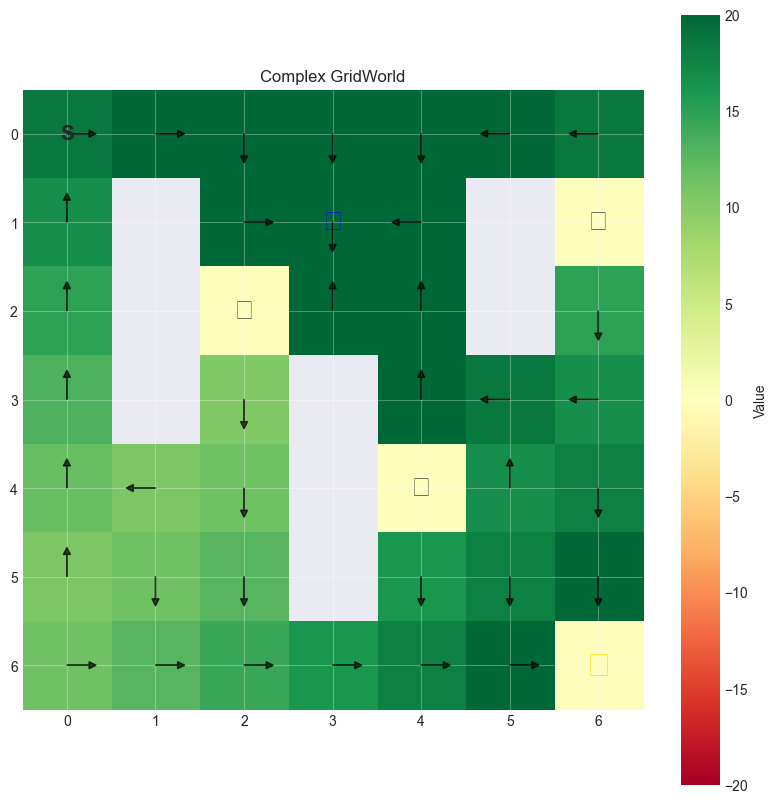

In [11]:
class ComplexGridWorld(GridWorldMDP):
    """복잡한 GridWorld 환경"""
    
    def __init__(self):
        super().__init__(7, 7)
        
        # 벽 위치
        self.walls = [
            State(1, 1), State(1, 2), State(1, 3),
            State(3, 3), State(3, 4), State(3, 5),
            State(5, 1), State(5, 2)
        ]
        
        # 여러 함정
        self.traps = [State(2, 2), State(4, 4), State(6, 1)]
        
        # 보상 지점
        self.rewards_dict = {
            State(3, 1): 5.0,  # 보너스 지점
            State(6, 6): 20.0  # 목표
        }
        
        self.goal_state = State(6, 6)
    
    def get_next_state(self, state: State, action: Action) -> State:
        """벽을 고려한 상태 전이"""
        if self.is_terminal(state):
            return state
        
        next_state = super().get_next_state(state, action)
        
        # 벽으로는 이동 불가
        if next_state in self.walls:
            return state
        
        return next_state
    
    def is_terminal(self, state: State) -> bool:
        """함정이나 목표에 도달하면 종료"""
        return state in self.traps or state == self.goal_state
    
    def get_reward(self, state: State, action: Action, next_state: State) -> float:
        """복잡한 보상 구조"""
        if next_state in self.traps:
            return -20.0
        elif next_state in self.rewards_dict:
            return self.rewards_dict[next_state]
        else:
            return -0.1
    
    def visualize(self, values: Optional[Dict[State, float]] = None, 
                  policy: Optional[Dict[State, Action]] = None):
        """복잡한 환경 시각화"""
        grid = np.zeros((self.height, self.width))
        
        if values:
            for state, value in values.items():
                grid[state.y, state.x] = value
        
        # 벽은 NaN으로 표시 (회색으로 보임)
        for wall in self.walls:
            grid[wall.y, wall.x] = np.nan
        
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # 가치 함수 히트맵
        masked_grid = np.ma.masked_invalid(grid)
        im = ax.imshow(masked_grid, cmap='RdYlGn', vmin=-20, vmax=20)
        
        # 정책 화살표
        if policy:
            for state, action in policy.items():
                if not self.is_terminal(state) and state not in self.walls:
                    dx, dy = 0, 0
                    if action == Action.UP: dy = -0.25
                    elif action == Action.DOWN: dy = 0.25
                    elif action == Action.LEFT: dx = -0.25
                    elif action == Action.RIGHT: dx = 0.25
                    
                    ax.arrow(state.x, state.y, dx, dy, 
                            head_width=0.08, head_length=0.08, 
                            fc='black', ec='black', alpha=0.7)
        
        # 특수 지점 표시
        for trap in self.traps:
            ax.text(trap.x, trap.y, '☠', ha='center', va='center', fontsize=20)
        
        for reward_state, reward in self.rewards_dict.items():
            if reward_state == self.goal_state:
                ax.text(reward_state.x, reward_state.y, '★', 
                       ha='center', va='center', fontsize=25, color='gold')
            else:
                ax.text(reward_state.x, reward_state.y, '◆', 
                       ha='center', va='center', fontsize=20, color='blue')
        
        ax.text(self.start_state.x, self.start_state.y, 'S', 
               ha='center', va='center', fontsize=15, fontweight='bold')
        
        # 격자
        ax.set_xticks(np.arange(self.width))
        ax.set_yticks(np.arange(self.height))
        ax.grid(True, alpha=0.3)
        
        plt.colorbar(im, ax=ax, label='Value')
        plt.title('Complex GridWorld')
        plt.show()

# 복잡한 환경에서 학습
complex_mdp = ComplexGridWorld()
print("복잡한 GridWorld 생성 완료")
print(f"벽: {len(complex_mdp.walls)}개, 함정: {len(complex_mdp.traps)}개")

# 가치 반복
print("\n가치 반복 실행 중...")
V_complex, policy_complex = value_iteration(complex_mdp, theta=0.001)

print("\n학습된 최적 정책:")
complex_mdp.visualize(values=V_complex, policy=policy_complex)

## 8. 요약 및 핵심 개념

### 이번 노트북에서 배운 내용

1. **MDP (Markov Decision Process)**
   - 강화학습 문제의 수학적 프레임워크
   - 상태, 행동, 보상, 전이 확률로 구성

2. **가치 함수**
   - 상태 가치 V(s): 특정 상태의 장기적 가치
   - 행동 가치 Q(s,a): 상태-행동 쌍의 가치
   - Bellman 방정식: 재귀적 관계

3. **동적 프로그래밍**
   - 정책 평가: 주어진 정책의 가치 계산
   - 가치 반복: 최적 가치 함수 직접 계산
   - 정책 반복: 평가와 개선 반복

4. **탐색 vs 활용**
   - ε-greedy: 균형잡힌 탐색 전략
   - 초기에는 탐색, 후반에는 활용

### 다음 노트북 예고
**Notebook 2: Q-learning과 SARSA**
- Model-free 학습 (환경 모델 없이)
- Temporal Difference 학습
- On-policy vs Off-policy
- 실제 에이전트 구현

In [ ]:
# 학습 체크포인트
print("🎯 학습 완료 체크리스트:")
print("✅ MDP 구조 이해")
print("✅ 가치 함수 계산")
print("✅ Bellman 방정식 적용")
print("✅ 정책 평가 구현")
print("✅ 가치 반복 구현")
print("✅ 정책 반복 구현")
print("✅ 탐색-활용 트레이드오프 이해")
print("\n🚀 다음 단계: Q-learning으로 모델 없이 학습하기!")